<H3><B>Data Cleaning </H3></B>

<H3><B>Importing Libraries</H3></B>

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
import math

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow'

<H3><B>Loading Data</H3></B>

In [3]:
df = pd.read_csv("traffic.csv")
data = df.copy() 
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


<H3><B>Data Exploration</H3></B>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


Text(0.5, 0, 'Date')

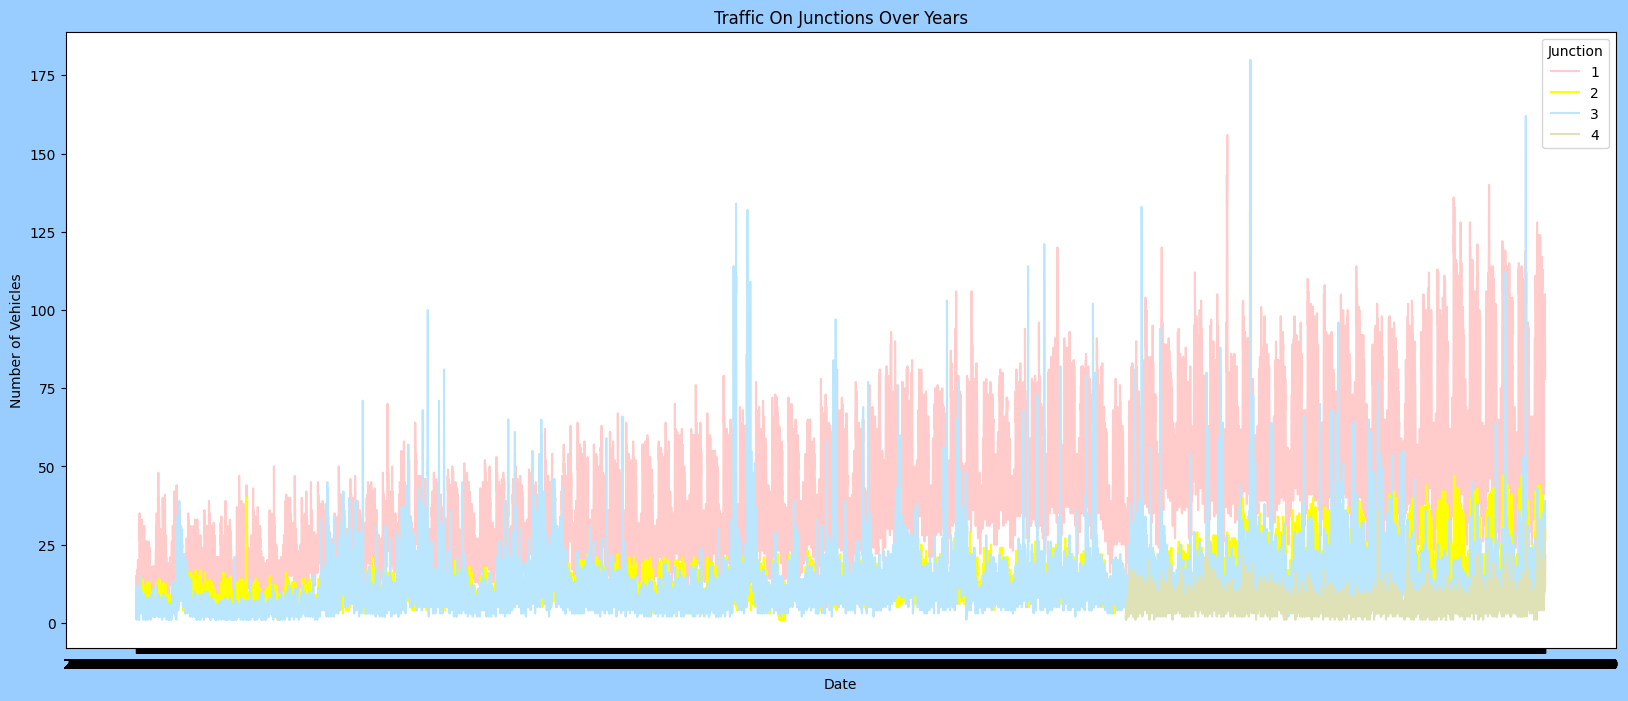

In [97]:
colors = ["#FFCCCB", "#ffff00","#BBE7FE","#dfe2b6"]
plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x=data['DateTime'],y="Vehicles",data=data, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

**Noticeable information in the above plot:**

* It can be seen here that the first junction is visibly having an upward trend.
* The data for the fourth junction is sparse starting only after 2017
* Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it. 

<H3><B>Feature Engineering</B></H3>

In [98]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Year'] = df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")

df.drop('DateTime', axis=1, inplace=True)
df.drop('ID', axis=1, inplace=True) 
df.head()

,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,1,15,2015,11,1,0,Sunday
1,1,13,2015,11,1,1,Sunday
2,1,10,2015,11,1,2,Sunday
3,1,7,2015,11,1,3,Sunday
4,1,9,2015,11,1,4,Sunday


<B><H3>Exploratory Data Analysis</H3></B>

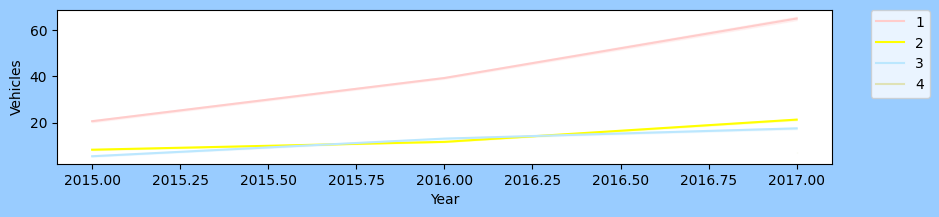

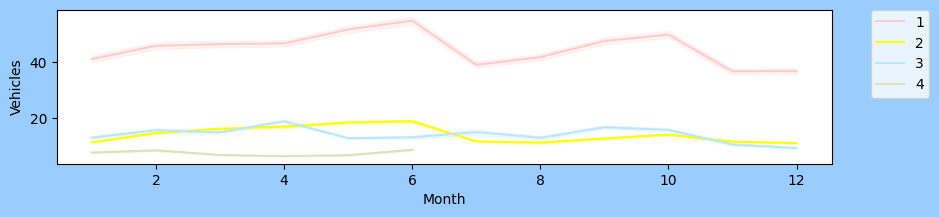

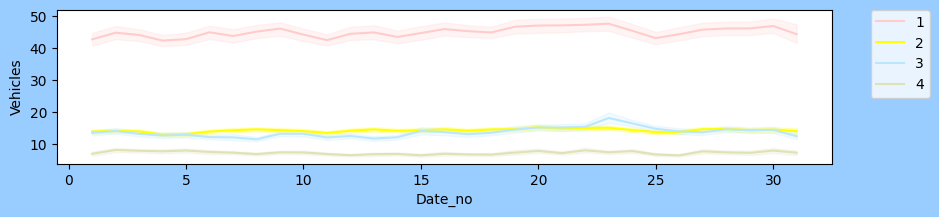

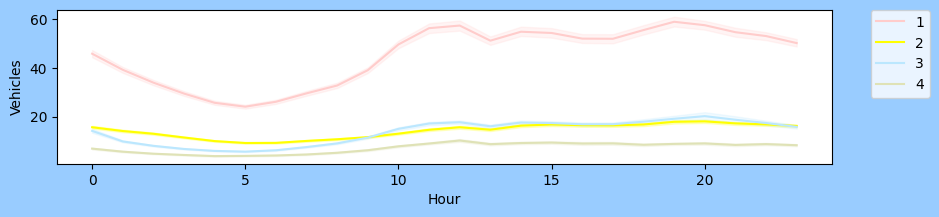

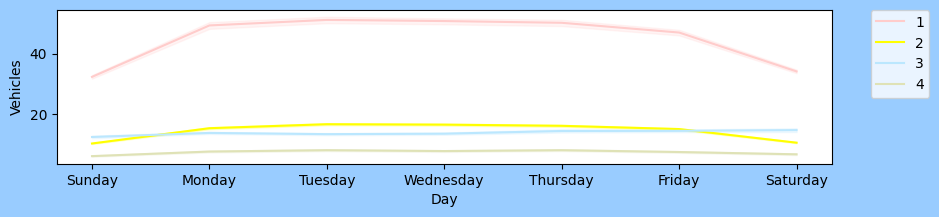

In [99]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]
for i in new_features:
    plt.figure(figsize=(10, 2),facecolor="#99ccff")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**From the above plot following things can be concluded:**


* Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.  

* We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same. 

* Monthly, throughout all the dates there is a good consistency in data. 

* For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation. 

* For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady. 

Text(0.5, 0, 'Date')

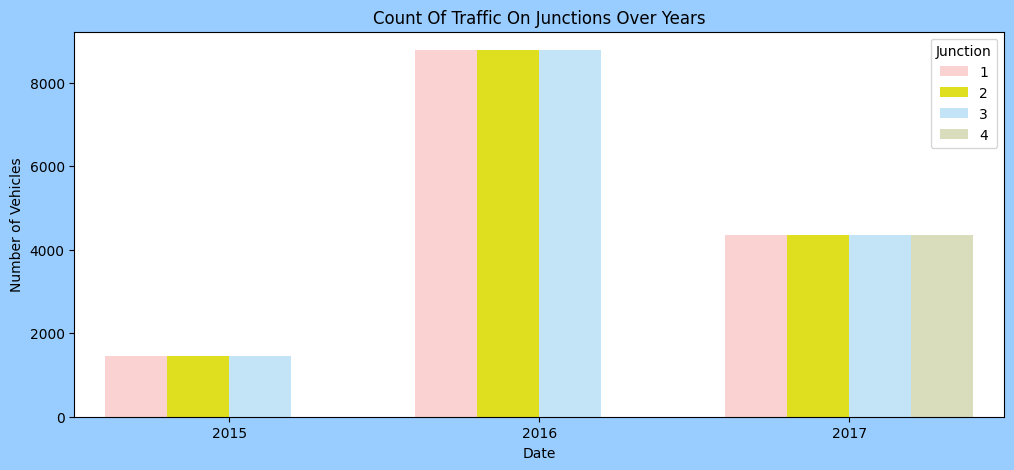

In [100]:
plt.figure(figsize=(12,5),facecolor="#99ccff")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month. 

<Axes: >

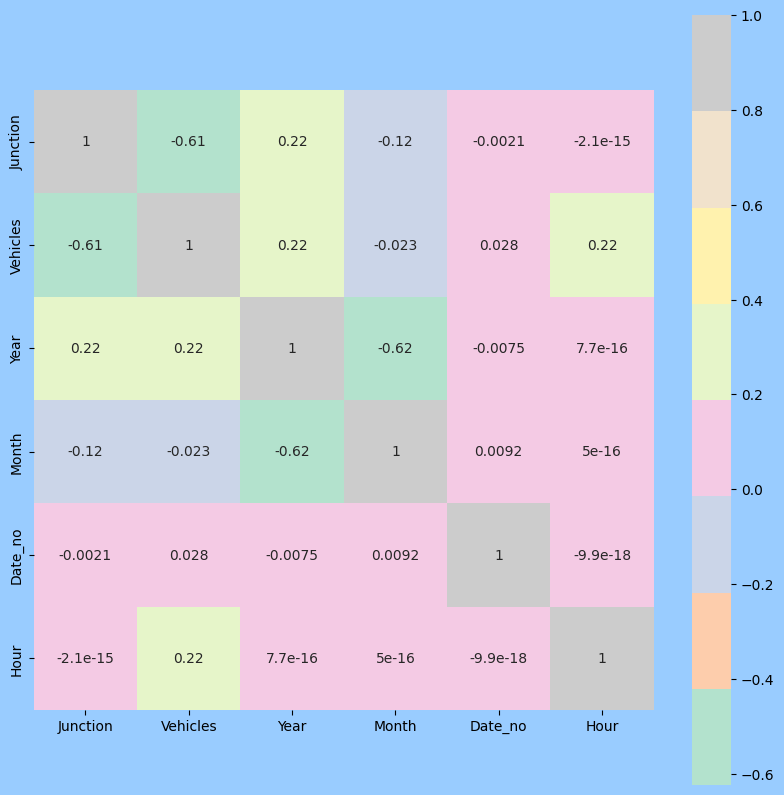

In [101]:
numeric_df = df.select_dtypes(include=[np.number])
corrmat = numeric_df.corr()

plt.subplots(figsize=(10,10),facecolor="#99ccff")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

The highest correlation is certainly with the preexisting features. So, we will conclude the EDA with a pair plot. 

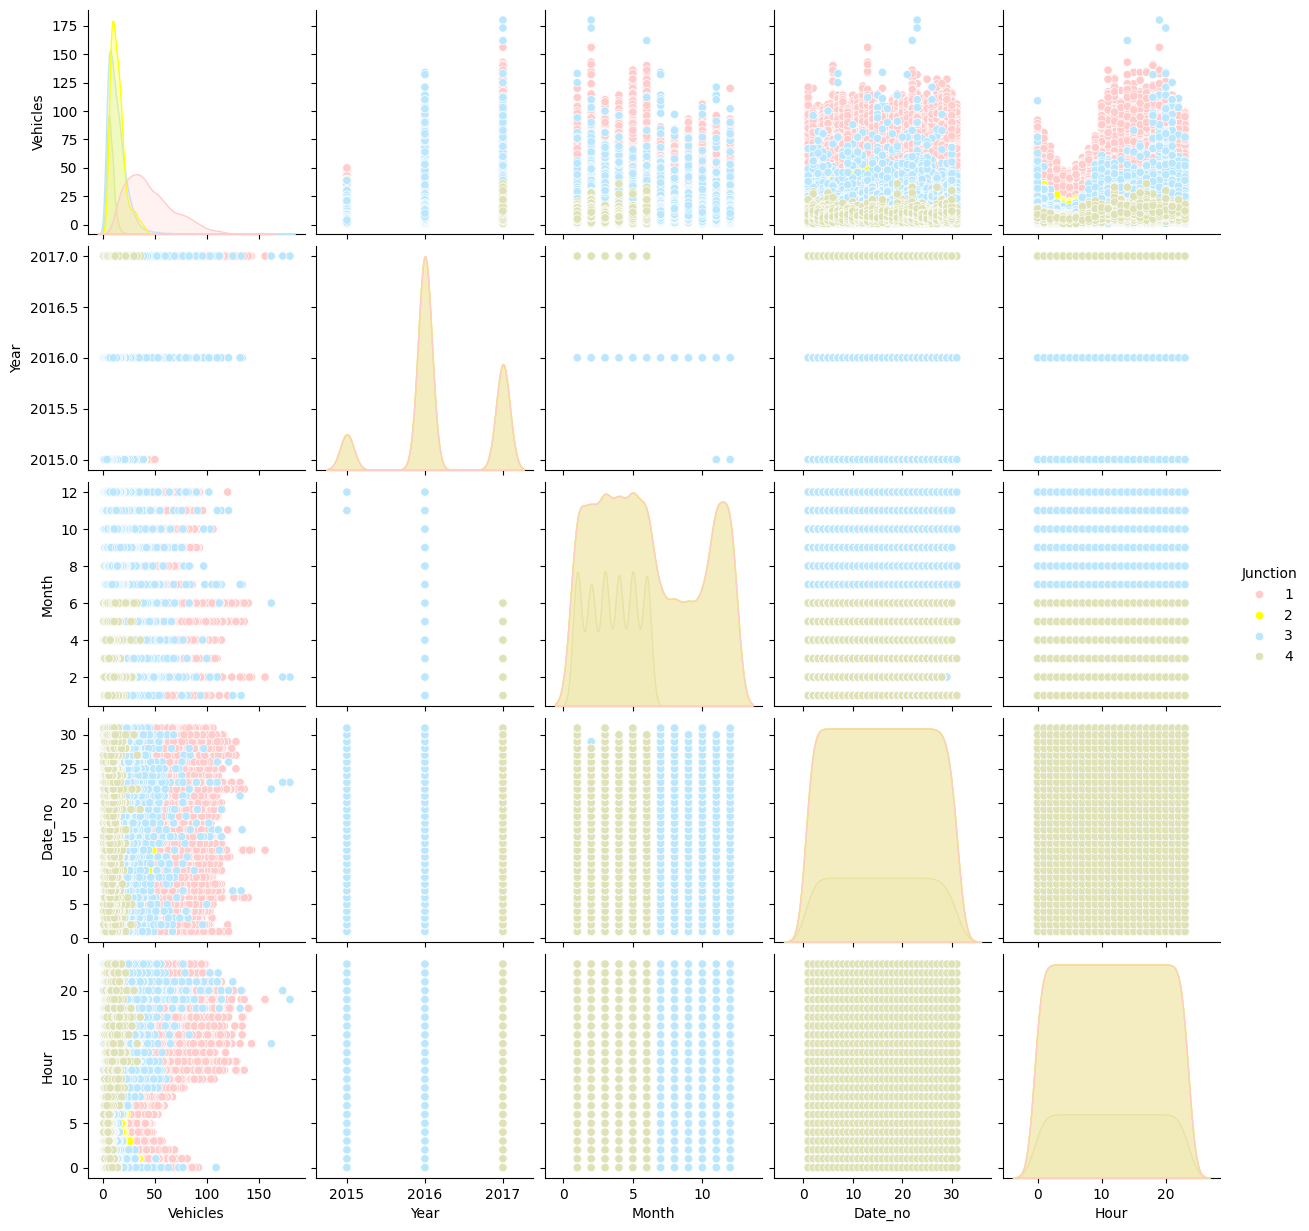

In [102]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Conclusions that I have come to draw after this EDA**

* The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
* The yearly trend for Junctions one, two and three have diffrent slopes. 
* Junction number one has a more strong weekly seasonality in comparison to the other junctions. 

For the above-postulated reasons, I think that junctions must be transformed as per their individual needs. 

<H3><B>Data Transformation & Preprocessing</H3></B>

In this step I will be following the subsequent order:
* Creating different frames for each Junction and plotting them
* Transforming the series and plotting them
* Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
* Creating test and train sets

In [103]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                                     ID  \
Junction             1             2             3            4             1   
count     14592.000000  14592.000000  14592.000000  4344.000000  1.459200e+04   
mean         45.052906     14.253221     13.694010     7.251611  2.016260e+10   
std          23.008345      7.401307     10.436005     3.521455  5.779594e+06   
min           5.000000      1.000000      1.000000     1.000000  2.015110e+10   
25%          27.000000      9.000000      7.000000     5.000000  2.016038e+10   
50%          40.000000     13.000000     11.000000     7.000000  2.016083e+10   
75%          59.000000     17.000000     18.000000     9.000000  2.017013e+10   
max         156.000000     48.000000    180.000000    36.000000  2.017063e+10   

                                                    
Junction             2             3             4  
count     1.459200e+04  1.459200e+04  4.344000e+03  
mean      2.016260e+10  2.016260e+10  2.017037e+10  
std       5.779594e+06  5.779594e+06  1.712987e+05  
min       2.015110e+10  2.015110e+10  2.017010e+10  
25%       2.016038e+10  2.016038e+10  2.017022e+10  
50%       2.016083e+10  2.016083e+10  2.017040e+10  
75%       2.017013e+10  2.017013e+10  2.017052e+10  
max       2.017063e+10  2.017063e+10  2.017063e+10

In [104]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#99ccff", sharey=True)
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    axes[0].set(ylabel ="Junction 1")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

**Steps for Transforming:**
* Normalizing 
* Differencing 

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:
* For Junction one, I will be taking a difference of weekly values. 
* For junction two, The difference of consecutive days is a better choice
* For Junctions three and four, the difference of the hourly values will serve the purpose. 

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

In [ ]:
#Plot of Transformed Dataframe
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

**Now that the data is stationary,  preprocessing the data for the neural net by:**

* Splitting the test train sets
* Assigning X as features and y as target 
* Reshaping data for neural net

In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

<B><H1> Model Building </H1></B>

Under Machine Learning Techniques, we will apply,
1. Linear Regression
2. Logistic Regression
3. K-Nearest Neighbour (KNN)

In [7]:
#Linear Regression
def Lin_Reg(X_Train, y_Train, X_Test, y_Test):
    model = LinearRegression()
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    y_pred = model.predict(X_Test)
    return y_pred

In [8]:
#Logistic Regression
def Log_Reg(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

Under Deep Learning Techniques, we will apply,
1. GRU (Gated Recurrent Unit)
2. LSTM (Long-Short Term Memory)
3. CNN (Convolutional Neural Networks)
4. MLP (Multi Layer Perceptron)

In [1]:
#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning.
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

In [2]:
# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The LSTM model 
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

In [3]:
# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The CNN model 
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

In [4]:
# MLP Model for the prediction
def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

<h3><b>Calculating Error </h3></b>

In [5]:
#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

In [6]:
#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#99ccff")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

<H3><B>Fitting The Model </H3></b>

We will now fit the transformed training sets of four junctions to the model created and compare them to the transformed test sets.

**Fitting the first junction and plotting the predictions and testset**

In [ ]:
#Predictions For First Junction
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
PredJ1_Lin = Lin_Reg(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ1_MLP = MLP_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

In [ ]:
# Results for J1 - Lin_Reg Model
print("\033[1;31;2m########------Linear Regression------########\033[0m")
RMSE_J1_Lin = RMSE_Value(y_testJ1, PredJ1_Lin)
PredictionsPlot(y_testJ1, PredJ1_Lin, 0)

# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)

# Results for J1 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

# Results for J1 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Linear Regression", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J1_Lin, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_1, best_model_rmse_1))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J1')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Second Junction
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
PredJ2_Lin = Lin_Reg(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

In [ ]:
# Results for J2 - Lin_Reg Model
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
RMSE_J2_Lin = RMSE_Value(y_testJ2, PredJ2_Lin)
PredictionsPlot(y_testJ2, PredJ2_Lin, 0)

# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)

# Results for J2 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)

# Results for J2 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Linear Regression", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J2_Lin, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_2, best_model_rmse_2))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J2')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Third Junction
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
PredJ3_Lin = Lin_Reg(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ3_LSTM = LSTM_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

In [ ]:
# Results for J3 - Lin_Reg Model
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
RMSE_J3_Lin = RMSE_Value(y_testJ3, PredJ3_Lin)
PredictionsPlot(y_testJ3, PredJ3_Lin, 0)

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J3_LSTM = RMSE_Value(y_testJ3, PredJ3_LSTM)
PredictionsPlot(y_testJ3, PredJ3_LSTM, 0)

# Results for J3 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)

# Results for J3 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
PredictionsPlot(y_testJ3, PredJ3_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Linear Regression", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J3_Lin, RMSE_J3_GRU, RMSE_J3_LSTM, RMSE_J3_CNN, RMSE_J3_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_3, best_model_rmse_3))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J3')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
PredJ4_Lin = Lin_Reg(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ4_LSTM = LSTM_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

In [ ]:
# Results for J4 - Lin_Reg Model
print("\033[1;31;2m########------Linear Regression Model------########\033[0m")
RMSE_J4_Lin = RMSE_Value(y_testJ4, PredJ4_Lin)
PredictionsPlot(y_testJ4, PredJ4_Lin, 0)

# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J4_LSTM = RMSE_Value(y_testJ4, PredJ4_LSTM)
PredictionsPlot(y_testJ4, PredJ4_LSTM, 0)

# Results for J4 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)

# Results for J4 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
PredictionsPlot(y_testJ4, PredJ4_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Linear Regression", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J4_Lin, RMSE_J4_GRU, RMSE_J4_LSTM, RMSE_J4_CNN, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_4, best_model_rmse_4))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J4')
plt.show()

display(styled_df)

<H3><B>Results of the Model </H3></B>

In [ ]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))

# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")   

The Root Mean Square Error is quite a subjective marker for evaluating the performance. Thus, in this project, we are including the outcome plots as well.

**Summary**

In this project, we trained a GRU, CNN, MLP, LSTM and my custom Model to predicted the traffic on four junctions. We used a normalisation and differencing transform to achieve a stationary timeseries. As the Junctions varry in trends and seasonality, we took diffrent approach for each junction to make it stationary. We applyied the root mean squred error as the evaluation metric for the model. In addition to that we plotted the Predictions alongside the original test values.

Take aways from the data analysis:

*The Number of vehicles in Junction one is rising more rapidly compaired to junction two and three. The sparsity of data in juction four bars me from making any conclusion on the same.*

*The Junction one's traffic has a stronger weekly seasonality as well as hourly seasonality. Where as other junctions are significantly linear.*


<H3><B>END</H3></B>